<a href="https://colab.research.google.com/github/samyaknd/movie-revenue-prediction/blob/main/movie_revenue_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud
from collections import Counter


### 1. Data Loading and Cleanup

I take look at columns that have significant amount of missing values

Also, In the dataset I saw that a few of the columns are JSON like strings, so I converted them to dictionaries so that they are easier to work with.

In [49]:
train=pd.read_csv('/content/train.csv')
test=pd.read_csv('/content/test.csv')

print(test.shape)
print(train.shape)
train.info()


(4398, 22)
(3000, 23)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     3000 non-null   int64  
 1   belongs_to_collection  604 non-null    object 
 2   budget                 3000 non-null   int64  
 3   genres                 2993 non-null   object 
 4   homepage               946 non-null    object 
 5   imdb_id                3000 non-null   object 
 6   original_language      3000 non-null   object 
 7   original_title         3000 non-null   object 
 8   overview               2992 non-null   object 
 9   popularity             3000 non-null   float64
 10  poster_path            2999 non-null   object 
 11  production_companies   2844 non-null   object 
 12  production_countries   2945 non-null   object 
 13  release_date           3000 non-null   object 
 14  runtime                2998 non-nu

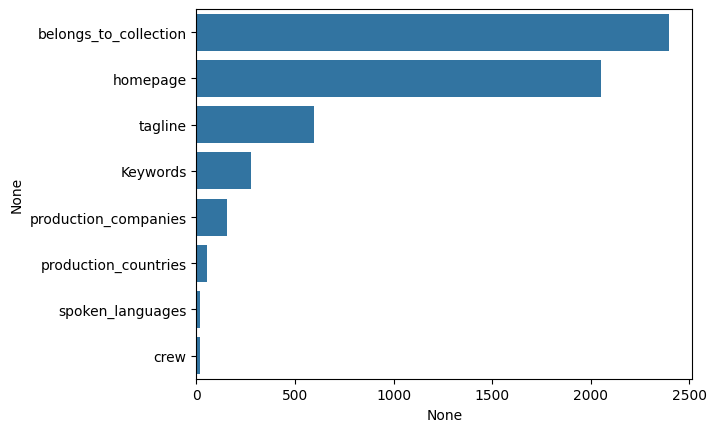

In [50]:
missing = train.isna().sum().sort_values(ascending=False)
sns.barplot(x=missing[:8],y=missing[:8].index)
plt.show()

In [51]:
import pandas as pd
import ast

dict_columns = ['belongs_to_collection', 'genres', 'production_companies',
                'production_countries', 'spoken_languages', 'Keywords', 'cast', 'crew']

def safe_literal_eval(val):
    try:
        if isinstance(val, str):
            return ast.literal_eval(val)
        elif isinstance(val, (dict, list)):
            return val
        else:
            return {}
    except (ValueError, SyntaxError):
        return {}

def text_to_dict(df):
    for column in dict_columns:
        df[column] = df[column].apply(lambda x: {} if x is None else safe_literal_eval(x))
    return df

print("Before transformation types:")
print(train['belongs_to_collection'].apply(type).head())

dfx = text_to_dict(train)
for col in dict_columns:
    train[col] = dfx[col]

print("After transformation types:")
print(train['belongs_to_collection'].apply(type).head())


Before transformation types:
0      <class 'str'>
1      <class 'str'>
2    <class 'float'>
3    <class 'float'>
4    <class 'float'>
Name: belongs_to_collection, dtype: object
After transformation types:
0    <class 'list'>
1    <class 'list'>
2    <class 'dict'>
3    <class 'dict'>
4    <class 'dict'>
Name: belongs_to_collection, dtype: object


In [52]:
dfx = text_to_dict(test)
for col in dict_columns:
    test[col] = dfx[col]

#### EDA:

I am going to do EDA on the following columns:

**belongs_to_collection:** Understanding the distribution and frequency of movie collections can reveal insights into the prevalence of franchises within the dataset, offering valuable information for analyzing patterns in movie success and audience engagement.

**tagline:** Examining the presence of taglines across movies allows for an understanding of how frequently movies utilize taglines as part of their marketing strategies, shedding light on their potential impact on audience perception and box office performance.

**keywords:** Investigating the most frequent and significant keywords within the movie dataset enables the identification of recurring themes and topics across films, providing valuable insights into audience interests and potential genre trends.

**production_companies:** Analyzing production companies' involvement in movie production offers insights into industry dynamics, highlighting the most active players and potential associations between production companies and specific movie genres or themes.

**production_countries:** Exploring production countries reveals global film industry trends, showcasing the dominance of key markets like Hollywood and identifying emerging film industries. It also reflects cultural influences, aids in localization strategies, and promotes diversity in filmmaking through international collaborations.

**spoken_languages:** Examining spoken languages in movies provides insights into audience demographics and preferences, aiding in localization efforts and marketing strategies tailored to specific language-speaking regions. It also reflects cultural diversity in filmmaking and highlights opportunities for language-specific content creation.

**genres:** Understanding the distribution of movie genres allows for insights into audience preferences and trends, aiding in content strategy and marketing decisions. It also provides context for analyzing the success and popularity of different genres within the movie dataset.

belongs_to_collection
0    2396
1     604
Name: count, dtype: int64


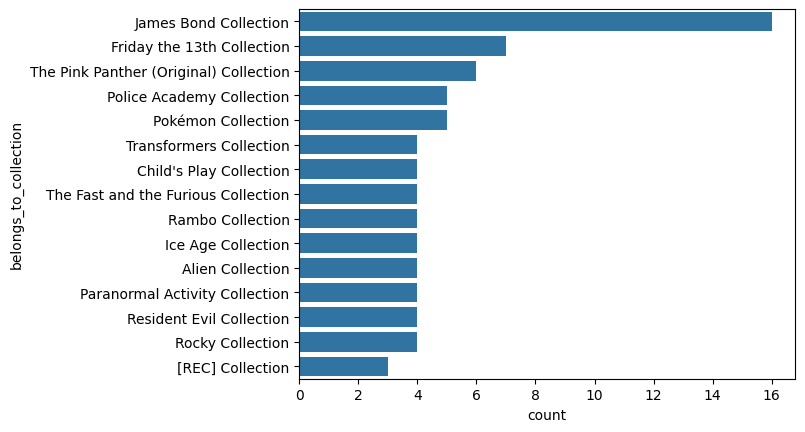

In [53]:
collections_count = train['belongs_to_collection'].apply(lambda x: len(x) if x else 0).value_counts()
print(collections_count)

top_collections = train['belongs_to_collection'].apply(lambda x: x[0]['name'] if x else None).value_counts()[0:15]
sns.barplot(x=top_collections, y=top_collections.index)
plt.show()

tagline
1    2403
0     597
Name: count, dtype: int64


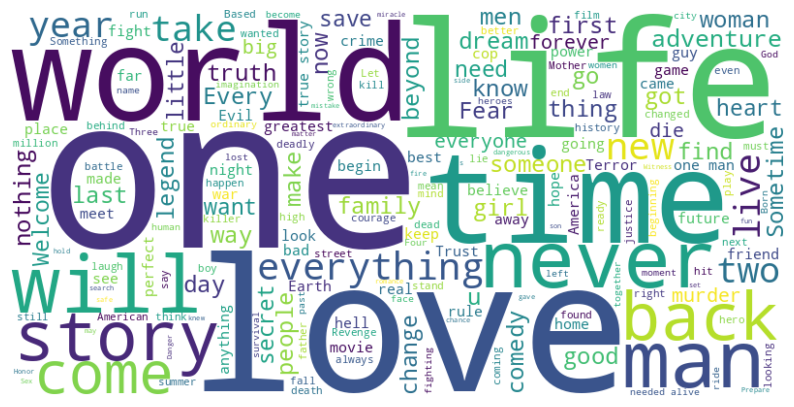

In [54]:
tagline_presence = train['tagline'].notna().astype(int).value_counts()
print(tagline_presence)

plt.figure(figsize=(10, 10))
all_taglines = ' '.join(train['tagline'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_taglines)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

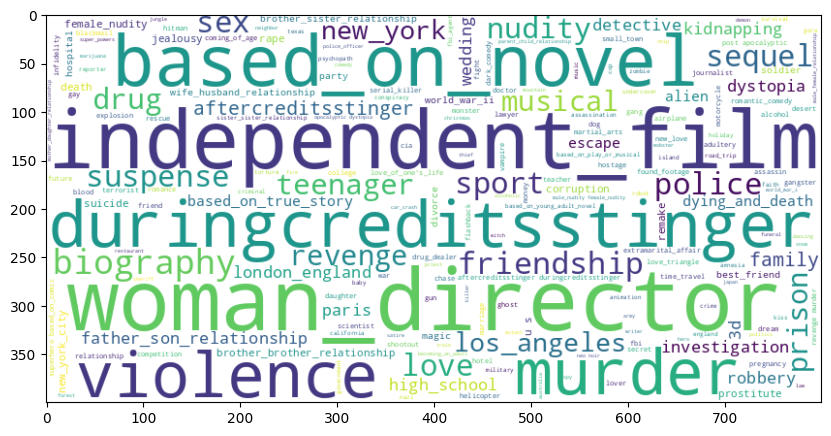

In [56]:
def extract_keywords(keywords):
  return [kw['name'] for kw in keywords] if isinstance(keywords, list) else []

list_of_keywords = train['Keywords'].apply(extract_keywords).tolist()
text = ' '.join('_'.join(kw.split()) for kws in list_of_keywords for kw in kws)

plt.figure(figsize=(10, 10))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

In [78]:
# def extract_country_names(countries):
#   return [country['name'] for country in countries] if isinstance(countries, list) else []

# country_names = train['production_countries'].apply(extract_country_names).tolist()

# country_count = Counter([name for sublist in country_names for name in sublist]).most_common(10)

# sns.barplot(x=[val[1] for val in country_count], y=[val[0] for val in country_count])
# plt.show()

# Here, I have written an abstraction for the above function so that I can resue it for different features

def extract_names(data, column_name, name_key):
    return [item[name_key] for sublist in data[column_name] for item in sublist] if isinstance(data[column_name].iloc[0], list) else []

def plot_most_common(data, column_name, name_key, top_n=10):
    names = extract_names(data, column_name, name_key)
    name_count = Counter(names).most_common(top_n)

    sns.barplot(x=[val[1] for val in name_count], y=[val[0] for val in name_count])
    plt.xlabel('Count')
    plt.ylabel('Name')
    plt.title(f'Top {top_n} Most Common {column_name.capitalize()}')
    plt.show()

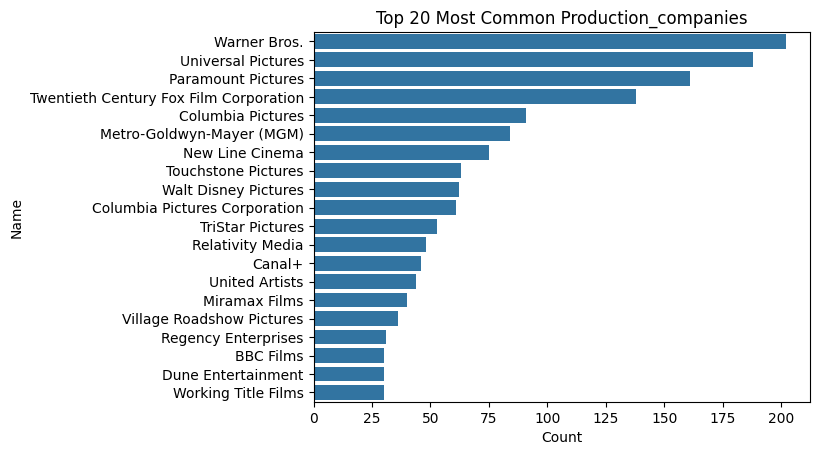

In [77]:
plot_most_common(train, 'production_companies', 'name', top_n=20)

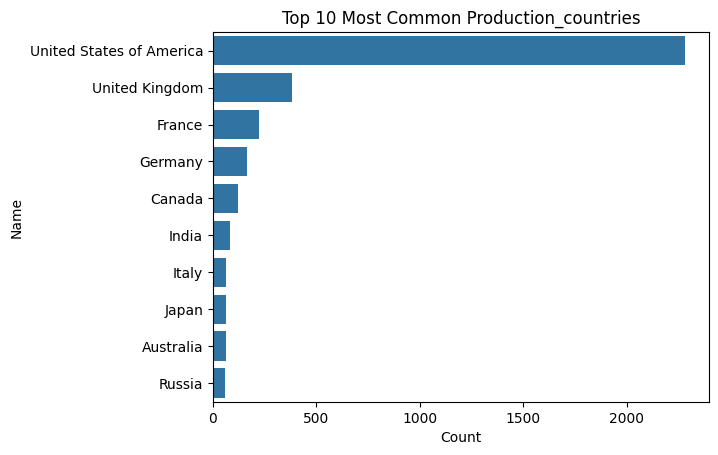

In [71]:
plot_most_common(train, 'production_countries', 'name', top_n=10)

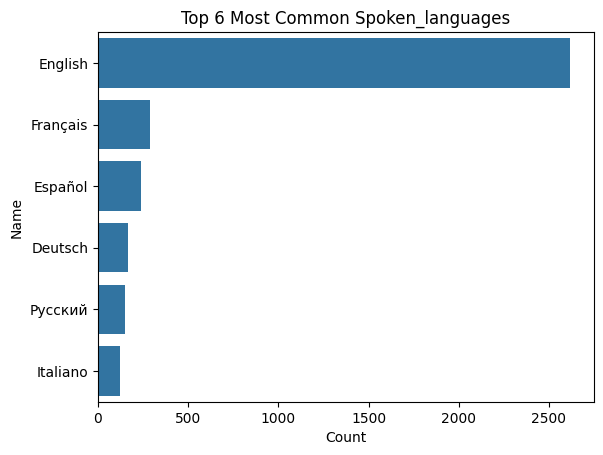

In [73]:
plot_most_common(train, 'spoken_languages', 'name', top_n=6)

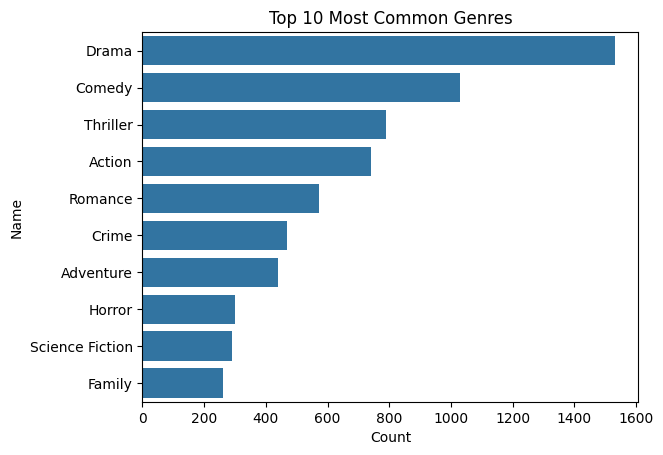

In [74]:
plot_most_common(train, 'genres', 'name', top_n=10)